<a href="https://colab.research.google.com/github/cn-mm/SOP-COVID-Tweets-Text-Classification/blob/master/RNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the repository 

In [1]:
# Cloning Repo
!git clone https://github.com/cn-mm/SOP-COVID-Tweets-Text-Classification.git

Cloning into 'SOP-COVID-Tweets-Text-Classification'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 57 (delta 22), reused 19 (delta 7), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [2]:
# Change directory 
%cd /content/SOP-COVID-Tweets-Text-Classification

/content/SOP-COVID-Tweets-Text-Classification


### Libraries

In [3]:
# Importing Libraries 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# nltk
import nltk 
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
stop=set(stopwords.words('english'))

# regex
import re

import gensim
import string

# Tensorflow 
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

# keras
import seaborn as sns
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, Activation 
from keras.initializers import Constant
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Install 
!pip install bert-tensorflow
!pip install sentencepiece

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Loading and Formatting Datasets 
Train and val sets denoted as TRAIN AND VAL and these will be used everywhere. They are kep constant. Val loss will be used for evaluation due to unavailability of test set. 

In [53]:
TRAIN = pd.read_csv(r'/content/SOP-COVID-Tweets-Text-Classification/train1.tsv', sep='\t')
VAL = pd.read_csv(r'/content/SOP-COVID-Tweets-Text-Classification/valid.tsv', sep = '\t')

##### Changing categprical labels 

In [110]:
def get_label(text):
    if text == "UNINFORMATIVE":
        return 0
    elif text == "INFORMATIVE":
        return 1
    else: 
        return -1

TRAIN['Label'] = TRAIN['Label'].apply(get_label)
VAL['Label'] = VAL['Label'].apply(get_label)

In [111]:
train = TRAIN
val = VAL

## Utils

In [7]:
"""
History and plotting epoch info 
"""
def plot_curves(history):
  print(history.history.keys())

  # summarize history for ACCURACY 
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for LOSS 
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## EDA

Simple analysis of data. Preprocessing is not required as the data provided did not have random characters or noise. It had already been removed. 

In [ ]:
"""
Distribution of labels (uninformative and informative)
"""
train.groupby('Label').count()

,Id,Text
Label,,
0,3660,3660
1,3272,3272


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of Informative and Uninformative Tweets')

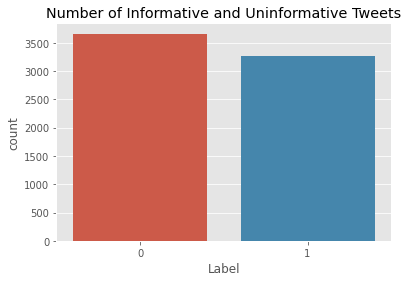

In [ ]:
import seaborn as sns
sns.countplot(train.Label)
plt.xlabel('Label')
plt.title('Number of Informative and Uninformative Tweets')

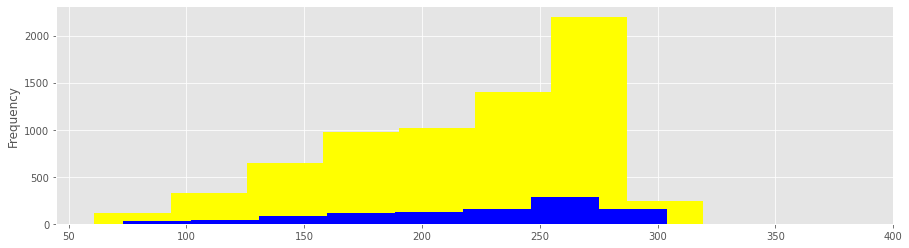

In [ ]:
# checking the distribution of string length of tweets in the data
# Train and Val 
length_train = train['Text'].str.len().plot.hist(color = 'yellow', figsize = (15, 4))
length_val = val['Text'].str.len().plot.hist(color = 'blue', figsize = (15, 4))

#### Most Commonly Occuring Words in the Vocab

Number of words in the vocabulary:  20154


Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

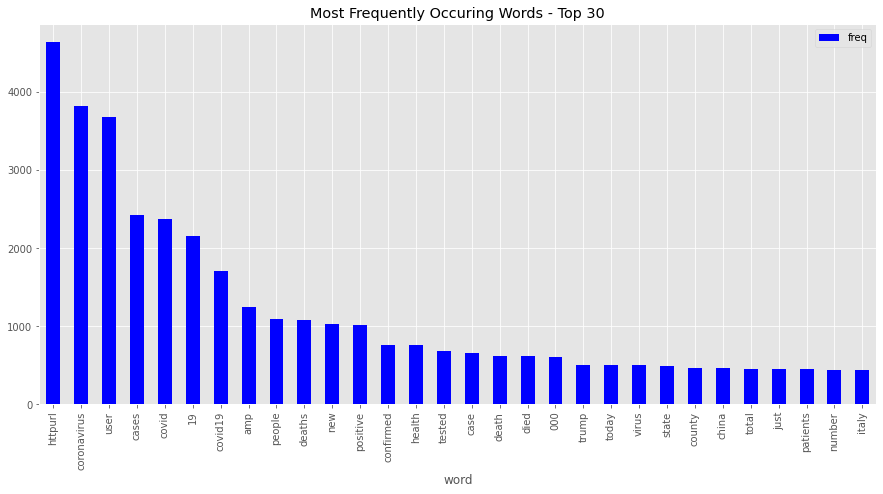

In [ ]:
def vocab_gen(text):
  """
  text: set of documents 
  Vocab generation
  1. Create an instance of the CountVectorizer class.
  2. Call the fit() function in order to learn a vocabulary from one or more documents.
  3. Call the transform() function on one or more documents as needed to encode each as a vector.
  """
  cv = CountVectorizer(stop_words = 'english')
  words = cv.fit_transform(text)  # encoded vector showing a count for each occurrence for each word 
  print(f"Number of words in the vocabulary: ", len(cv.vocabulary_.items())) 
  return words

def word_freq(words):
  """
  word_freq: Returns a sort list of tuple of words and the word count in the set of documents 
  """
  sum_words = words.sum(axis=0)
  words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
  frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

  return frequency

words = vocab_gen(train.Text)
frequency = word_freq(words)
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

#### Hashtag analysis

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


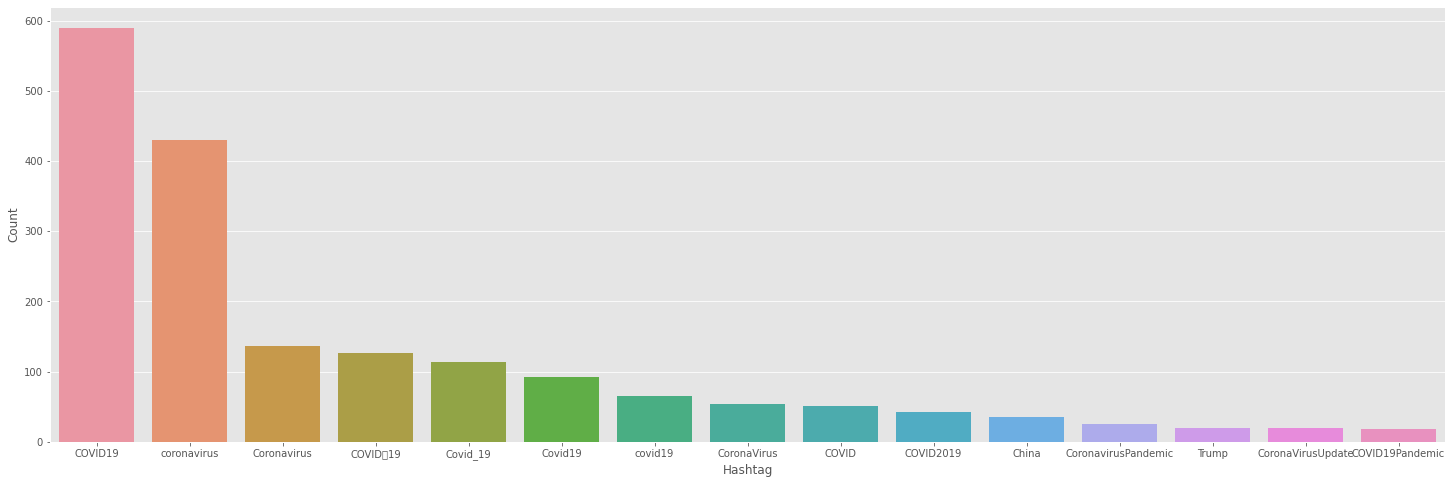

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


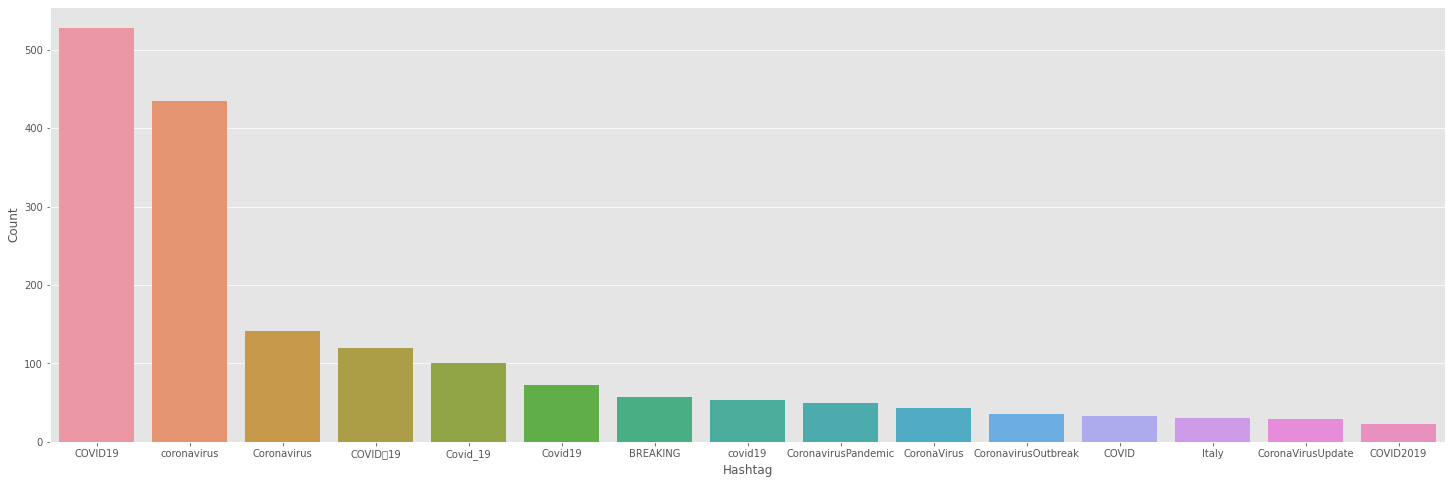

In [ ]:
""" 
Hashtag Extraction without using the Tweet Tokenizer
Returns un nested list containing hashtags 
"""
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return sum(hashtags,[])

# extracting hashtags from uninformative tweets
h_un = hashtag_extract(train['Text'][train['Label'] == 0])

# extracting hashtags from informative tweets
h_in = hashtag_extract(train['Text'][train['Label'] == 1])

def ht_plot(ht_list, num):
  freq = nltk.FreqDist(ht_list)
  hashtag_df = pd.DataFrame({'Hashtag': list(freq.keys()),
                  'Count': list(freq.values())})
  
  # selecting top n most frequent hashtags     
  hashtag_df = hashtag_df.nlargest(columns="Count", n = num) 
  plt.figure(figsize=(25,8))
  ax = sns.barplot(data=hashtag_df, x= "Hashtag", y = "Count")
  ax.set(ylabel = 'Count')
  plt.show()
    
# 10 most common hashtags in uninformative set
ht_plot(h_un, 15)
ht_plot(h_in, 15)

# Gaussian and Regression

In [ ]:
""""
To be added
""""

# RNN Model


Combining train and val due to unavailability of test set. We will be spliting this on our own. 

In [ ]:
trainval = TRAIN.append(VAL, ignore_index= True)
# trainval['Text']

In [ ]:
"""
Params fot the RNN model 
"""
max_words = 22000 # generally vocab of the set 
max_len = 80 # max num words in a tweet 

"""
Encode the data 
"""
def encode_text(trainval, setlower = False):
  le = LabelEncoder()
  # Try using lowercase only once 
  if setlower: X = trainval.Text.str.lower() 
  else: X = trainval.Text
  Y = trainval.Label
  Y = le.fit_transform(Y)
  Y = Y.reshape(-1,1)
  return X, Y

"""
Tokenizing input 
"""
def tokenize_this(X, mlen = 80):
  tok = Tokenizer() # using keras tokenizer here
  k = tok.fit_on_texts(X)   
  sequences = tok.texts_to_sequences(X) 
  sequences_matrix = sequence.pad_sequences(sequences,maxlen=mlen) # padded, tokenized input sequences 

  return sequences, sequences_matrix

  """
RNN with LSTM Model definition
"""
def RNN():
    inputs = Input(name='inputs',shape=[max_len]) # here shape taken as max no. of words in a tweet 
    layer = Embedding(25000,50,input_length=max_len)(inputs) # input dim = max words, output dim = 50, input len = max_len 
    layer = LSTM(64)(layer)
    layer = Dropout(0.8)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.8)(layer)
    layer = Dense(1,name='out_layer')(layer) # output layer 
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

"""
Training the model
"""
# create, compile and fit the model
def train_RNN_model(sequences_matrix, Y, loss='binary_crossentropy', op = 'adam', 
                    epochs = 10, validation_split = 0.2, shuffle = True, batch_size = 128):
  model = RNN()
  model.compile(loss=loss , optimizer= op, metrics=['accuracy'])
  history = model.fit(sequences_matrix , Y, batch_size=batch_size ,epochs=epochs ,validation_split=0.2, 
                      shuffle = shuffle , callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
  return history 

Epoch 1/10
100/100 [==============================] - 2s 23ms/step - loss: 0.6808 - accuracy: 0.5600 - val_loss: 0.5308 - val_accuracy: 0.7215
Epoch 2/10
100/100 [==============================] - 2s 19ms/step - loss: 0.4144 - accuracy: 0.8326 - val_loss: 0.3881 - val_accuracy: 0.8305
Epoch 3/10
100/100 [==============================] - 2s 19ms/step - loss: 0.1680 - accuracy: 0.9442 - val_loss: 0.6230 - val_accuracy: 0.8248
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


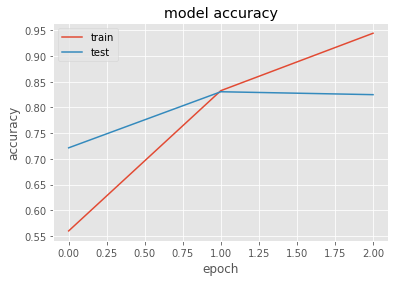

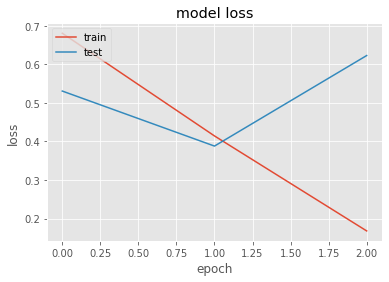

In [ ]:
"""
Function
"""
X, Y = encode_text(trainval, setlower= True)
_, sequences_mat = tokenize_this(X, max_len)
history = train_RNN_model(sequences_mat, Y, batch_size = 64)
plot_curves(history)

In [ ]:
"""
Epochs 3-4 as we have used callback 

batch_size 128
accuracy: 0.9738 - val_loss: 0.5563 - val_accuracy: 0.8204
accuracy: 0.9032 - val_loss: 0.5225 - val_accuracy: 0.8185
accuracy: 0.9644 - val_loss: 0.4824 - val_accuracy: 0.8179

batch size 64
accuracy: 0.9433 - val_loss: 0.4900 - val_accuracy: 0.8299
accuracy: 0.9281 - val_loss: 0.4096 - val_accuracy: 0.8431
accuracy: 0.9343 - val_loss: 0.4404 - val_accuracy: 0.8009
accuracy: 0.9401 - val_loss: 0.4479 - val_accuracy: 0.8141
accuracy: 0.9398 - val_loss: 0.4951 - val_accuracy: 0.8336
with set lower
accuracy: 0.9169 - val_loss: 0.4111 - val_accuracy: 0.8311

batch size 16
accuracy: 0.9604 - val_loss: 0.4843 - val_accuracy: 0.8173
accuracy: 0.9546 - val_loss: 0.4881 - val_accuracy: 0.8160
"""

# Strangely enough pre and post padding makes a huge difference, why? 

'\nEpochs 3-4 as we have used callback \n\nbatch_size 128\naccuracy: 0.9738 - val_loss: 0.5563 - val_accuracy: 0.8204\naccuracy: 0.9032 - val_loss: 0.5225 - val_accuracy: 0.8185\naccuracy: 0.9644 - val_loss: 0.4824 - val_accuracy: 0.8179\n\nbatch size 64\naccuracy: 0.9433 - val_loss: 0.4900 - val_accuracy: 0.8299\naccuracy: 0.9281 - val_loss: 0.4096 - val_accuracy: 0.8431\naccuracy: 0.9343 - val_loss: 0.4404 - val_accuracy: 0.8009\naccuracy: 0.9401 - val_loss: 0.4479 - val_accuracy: 0.8141\naccuracy: 0.9398 - val_loss: 0.4951 - val_accuracy: 0.8336\nwith set lower\naccuracy: 0.9169 - val_loss: 0.4111 - val_accuracy: 0.8311\n\nbatch size 16\naccuracy: 0.9604 - val_loss: 0.4843 - val_accuracy: 0.8173\naccuracy: 0.9546 - val_loss: 0.4881 - val_accuracy: 0.8160\n'

# Glove embeddings 

### Download pre trained embeddings

In [8]:
"""
Caution: This cell may take 4-5 minutes to run 
Use in case glove embeddings not available on the drive
"""
# file_name = "glove.6B.zip"
file_name = "glove.twitter.27B.zip"
!wget http://nlp.stanford.edu/data/{file_name}

--2020-11-30 18:04:14--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-11-30 18:04:15--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-11-30 18:04:15--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [9]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [10]:
!ls
!pwd

About_The_Data.ipynb	    NaiveBayesLR.ipynb
COVID19Tweet-master.zip     Preprocessing.ipynb
glove.twitter.27B.100d.txt  README.md
glove.twitter.27B.200d.txt  RNNs.ipynb
glove.twitter.27B.25d.txt   train1.tsv
glove.twitter.27B.50d.txt   train.tsv
glove.twitter.27B.zip	    unlabeled_test_with_noise.tsv
Models.ipynb		    valid.tsv
/content/SOP-COVID-Tweets-Text-Classification


### Import Embedding Files from Google drive

In [ ]:
# Get embedding info from drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/1_SOP_NLP/glove.6B.zip"

Archive:  /content/gdrive/My Drive/1_SOP_NLP/glove.6B.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        


In [ ]:
!unzip "/content/gdrive/My Drive/1_SOP_NLP/glove.twitter.27B.zip"

Archive:  /content/gdrive/My Drive/1_SOP_NLP/glove.twitter.27B.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


### Model Functions and Training 

In [ ]:
"""
Model params 
"""
MAX_LEN=80  # put in utils?
embedding_dims = 100  # specify the dimensions of embedding vector 

"""
Create corpus, all words in the vocabulary
"""
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['Text']):
        words=[word.lower() for word in word_tokenize(tweet)] # using nltk's word tokenizer
        # words=[word.lower() for word in TweetTokenizer(tweet)]
        corpus.append(words)
    return corpus 

"""
Create an embedding dictionary using GloVe vectors 
word and corresponding vector 
"""
def get_embeddings_dict(filename):
  embedding_dict={}
  with open(filename,'r', encoding='utf8') as f:
    for line in f:
      values=line.split()
      word = values[0]
      vectors=np.asarray(values[1:],'float32')
      embedding_dict[word]=vectors
  f.close()
  return embedding_dict

# '/content/SOP-COVID-Tweets-Text-Classification/glove.6B.100d.txt
# '/content/SOP-COVID-Tweets-Text-Classification/glove.twitter.27B.100d.txt


"""
Tokenizer
"""
# seq, _ = tokenize_this(X, MAX_LEN) try using the prev function find difference 

def tokenize_and_pad(corpus):
  tokenizer_obj = Tokenizer()
  tokenizer_obj.fit_on_texts(corpus)
  sequences=tokenizer_obj.texts_to_sequences(corpus)
  padded_tweets = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post') # padded tweets 
  word_dict = tokenizer_obj.word_index # word index is the mapping words to integer, will be a dictionary 
  return padded_tweets, word_dict

"""
Embedding Matrix
"""
def get_embedding_matrix(word_dict, embedding_dims=100):
  num_words=len(word_dict)+1 # words in vocab 
  embedding_matrix=np.zeros((num_words,embedding_dims))  # padded embedding matrix 100 because 100 dimensional embeddings 
  for word,i in tqdm(word_dict.items()):
    if i < num_words: # boundary condition, not necessary 
      emb_vec=embedding_dict.get(word)  # create embedding vector 
      if emb_vec is not None:
        embedding_matrix[i]=emb_vec           

  return num_words, embedding_matrix

"""
Generate Train and Test sets 
"""
def train_inputs(tweet_pad, val_split_ratio = 0.2):
  train_set = tweet_pad[:train.shape[0]] # (7932, 80)
  X_train, X_test, y_train, y_test = train_test_split(train_set ,
                                                      train['Label'].values,
                                                      test_size=val_split_ratio)
  return X_train, X_test, y_train, y_test


In [ ]:
def glove_model(embedding_matrix, mlen):
  model=Sequential()
  embedding=Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                      embeddings_initializer=Constant(embedding_matrix),
                    input_length=mlen,trainable=False)
  model.add(embedding)
  model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  # model.add(Dense(128, activation='relu'))
  # model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  return model

def train_model_glove(X_train, y_train, X_test, y_test, embedding_matrix, 
                      mlen = 80, batch_size=64, epochs=5):
  model = glove_model(embedding_matrix, mlen)
  optimzer=Adam(learning_rate=3e-4)
  model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])
  history=model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,
                    validation_data=(X_test,y_test),verbose=2) 
  return history

In [ ]:
"""
Functions 
""" 
train = TRAIN.append(VAL, ignore_index= True)
corpus=create_corpus_new(train)
embedding_dict = get_embeddings_dict('glove.6B.100d.txt') # give embedding file name 
tweet_pad, word_index = tokenize_and_pad(corpus)
num_words, embedding_matrix = get_embedding_matrix(word_index, embedding_dims)
X_train, X_test, y_train, y_test = train_inputs(tweet_pad)

# seq, tp = tokenize_this(corpus, MAX_LEN)

In [ ]:
"""
Model creation and training 
"""
model = glove_model(embedding_matrix, MAX_LEN)
model.summary()
history = train_model_glove(X_train, y_train, X_test, y_test, embedding_matrix, MAX_LEN)
plot_curves(history)

#### Trial and Error and a graph

In [ ]:
# model=Sequential()

# embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
#                    input_length=MAX_LEN,trainable=False)
# model.add(embedding)
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
# optimzer=Adam(learning_rate=3e-4)
# model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

Epoch 1/5
100/100 - 26s - loss: 0.6878 - accuracy: 0.5275 - val_loss: 0.6714 - val_accuracy: 0.6326
Epoch 2/5
100/100 - 25s - loss: 0.5632 - accuracy: 0.7351 - val_loss: 0.5150 - val_accuracy: 0.7839
Epoch 3/5
100/100 - 25s - loss: 0.5174 - accuracy: 0.7710 - val_loss: 0.5101 - val_accuracy: 0.7662
Epoch 4/5
100/100 - 26s - loss: 0.4747 - accuracy: 0.7943 - val_loss: 0.4455 - val_accuracy: 0.8059
Epoch 5/5
100/100 - 26s - loss: 0.4444 - accuracy: 0.8050 - val_loss: 0.4530 - val_accuracy: 0.8078


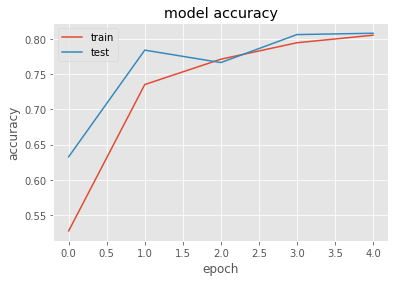

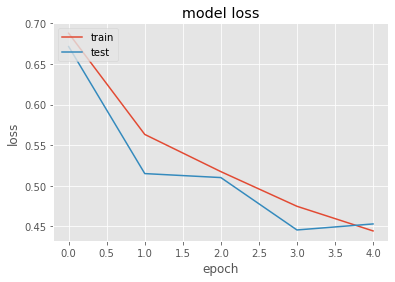

In [ ]:
history=model.fit(X_train,y_train,batch_size=64,epochs=5,validation_data=(X_test,y_test),verbose=2) #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.000001)]) 
# history=model.fit(X_train,y_train,batch_size=64,epochs=5,validation_data=(X_test,y_test),verbose=2) #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.000001)])

# model.fit(sequences_matrix,Y,batch_size=128,epochs=10,validation_split=0.2, shuffle = True , callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Epoch 5/5
# 100/100 - 27s - loss: 0.3209 - accuracy: 0.8638 - val_loss: 0.3337 - val_accuracy: 0.8658
# Epoch 5/5
# 100/100 - 27s - loss: 0.2957 - accuracy: 0.8720 - val_loss: 0.3229 - val_accuracy: 0.8765

# Can do 30 then 


# BERT


In [ ]:
# Trial Notebook only for understanding BERT Implementation 
# https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert
# https://github.com/google-research/bert
# https://aihub.cloud.google.com/u/0/p/products%2F5f7e984e-f2e7-445f-9808-7ce751dcc1da
!pip install bert-tensorflow
!pip install sentencepiece
"""
SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems
where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units
(e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct 
training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on 
language-specific pre/postprocessing.
"""

     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 1.1MB 4.3MB/s 


'\nSentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems\nwhere the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units\n(e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct \ntraining from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on \nlanguage-specific pre/postprocessing.\n'

In [14]:
# Bert's own tokenizer
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [17]:
# imported from sentencepiece 
import tokenization 

#### BERT Models

In [ ]:
# Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

#### BERT Implementation

In [11]:
"""
Encode train text with tokenizer
"""
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

"""
Build BERT model 
"""
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if Dropout_num == 0:
        # Without Dropout
        out = Dense(1, activation='sigmoid')(clf_output)
    else:
        # With Dropout(Dropout_num), Dropout_num > 0
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
""" 
BERT Large uncased model 
"""
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [18]:
"""
The tokenization of input text can be performed in Python with the FullTokenizer class 
from tensorflow/models/official/nlp/bert/tokenization.py. Its vocab_file is stored as 
atf.saved_model.Asset and the do_lower_case flag is stored as a tf.Variable object on the SavedModel.
"""
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [19]:
train = TRAIN
test = VAL

In [28]:

# Encode the text into tokens, masks, and segment flags
train_input = bert_encode(train.Text.values, tokenizer, max_len=160)
test_input = bert_encode(test.Text.values, tokenizer, max_len=160)
train_labels = train.Label.values

### Params 

In [29]:
random_state_split = 2
Dropout_num = 0
learning_rate = 6e-6
valid = 0.15
epochs_num = 4
batch_size_num = 16 # kept low to avoid resource exhaution 
target_corrected = False
target_big_corrected = False

In [30]:
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
# Train BERT model with my tuning
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = valid,
    epochs = epochs_num, # recomended 3-5 epochs
    callbacks=[checkpoint],
    batch_size = batch_size_num
)

In [ ]:
# Prediction by BERT model with my tuning
model_BERT.load_weights('model_BERT.h5')
test_pred_BERT = model_BERT.predict(test_input)
test_pred_BERT_int = test_pred_BERT.round().astype('int')

In [ ]:
# Prediction by BERT model with my tuning for the training data - for the Confusion Matrix
train_pred_BERT = model_BERT.predict(train_input)
train_pred_BERT_int = train_pred_BERT.round().astype('int')

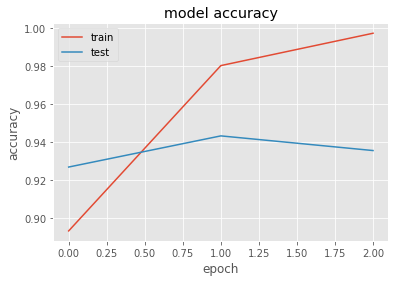

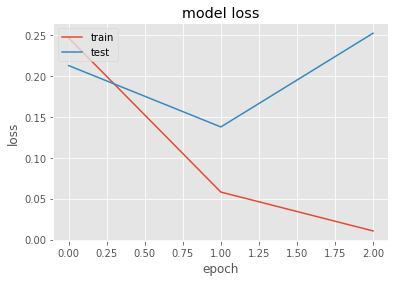

In [ ]:
history = train_history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# BERT 2.0

In [33]:
!pip install -q tf-models-official

     |████████████████████████████████| 849kB 15.9MB/s 
     |████████████████████████████████| 358kB 51.1MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 36.7MB 81kB/s 
     |████████████████████████████████| 174kB 51.8MB/s 


In [35]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 2.6MB 12.2MB/s 


In [36]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [68]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/1',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [69]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [70]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [71]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [72]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [103]:
TRAIN_NO_ID = TRAIN.drop('Id', axis = 1)

In [105]:
# rslt_df = dataframe[dataframe['Percentage'] > 80] 
  
TRAIN_UN = TRAIN_NO_ID[TRAIN_NO_ID['Label'] == 0]
TRAIN_IN = TRAIN_NO_ID[TRAIN_NO_ID['Label'] == 1]

In [106]:
def write_to_txt_file(writePath, df):
  with open(writePath, 'w') as f:
    for text in df['Text'].tolist():
        f.write(text + '\n')
  f.close()

In [107]:
writePath1 = "/content/SOP-COVID-Tweets-Text-Classification/raw/un.txt"
writePath2 = "/content/SOP-COVID-Tweets-Text-Classification/raw/in.txt"
write_to_txt_file(writePath1, TRAIN_UN)
write_to_txt_file(writePath2, TRAIN_IN)